In [1]:
library(tidyverse)
library(fpp3)
library(forecast)

-- Attaching packages --------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.3     v purrr   0.3.4
v tibble  3.1.0     v dplyr   1.0.5
v tidyr   1.1.4     v stringr 1.4.0
v readr   2.1.2     v forcats 0.5.1

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

-- Attaching packages -------------------------------------------- fpp3 0.4.0 --

v lubridate   1.8.0     v feasts      0.2.2
v tsibble     1.1.1     v fable       0.3.1
v tsibbledata 0.4.0     

-- Conflicts ------------------------------------------------- fpp3_conflicts --
x lubridate::date()    masks base::date()
x dplyr::filter()      masks stats::filter()
x tsibble::intersect() masks base::intersect()
x tsibble::interval()  masks lubridate::interval()
x dplyr::lag()         masks stats::lag()
x tsibble::setdiff()   masks base::setdiff()
x tsibble::union()     masks base::union()

Registered S3 method 

# Objetivos
El objetivo de esta actividad es encontrar el mejor modelo ARIMA para la serie temporal de matriculaciones de vehículos 2013-2022. Obtenida de datos oficiales ministerio de Economía:

http://serviciosede.mineco.gob.es/Indeco/reports/verSerieGraf.aspx/?codigo=271200&frec=-1

## Cargamos los datos y los dividimos en train (2013-2020) y test (julio 2020 - 2022)

In [2]:
serie <- read_delim("Serie_matricula_vehiculos_2003-22.tsv", "\t")

summary(serie)
names(serie)[2] <- "matriculaciones"

# Para facilitarnos la vida al pasar a fecha, añadimos día

serie$Periodo <- paste("01-", serie$Periodo)

serie$Periodo <- as.Date(serie$Periodo, format = "%d-%m-%Y")

summary(serie)

serie_2020 <- serie %>%
  dplyr::filter(Periodo <=  as.Date("2020-02-01"))


serie_2022<- serie %>%
  dplyr::filter(Periodo >=  as.Date("2020-07-01"))


summary(serie_2020)
summary(serie_2022)

Rows: 231 Columns: 2

-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (1): Periodo
dbl (1): matriculaciones


i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.



   Periodo          matriculaciones 
 Length:231         Min.   :  4764  
 Class :character   1st Qu.: 72358  
 Mode  :character   Median : 98424  
                    Mean   : 99452  
                    3rd Qu.:125455  
                    Max.   :181139  

    Periodo           matriculaciones 
 Min.   :2003-01-01   Min.   :  4764  
 1st Qu.:2007-10-16   1st Qu.: 72358  
 Median :2012-08-01   Median : 98424  
 Mean   :2012-07-31   Mean   : 99452  
 3rd Qu.:2017-05-16   3rd Qu.:125455  
 Max.   :2022-03-01   Max.   :181139  

    Periodo           matriculaciones 
 Min.   :2003-01-01   Min.   : 36309  
 1st Qu.:2007-04-08   1st Qu.: 74263  
 Median :2011-07-16   Median :102731  
 Mean   :2011-07-17   Mean   :102379  
 3rd Qu.:2015-10-24   3rd Qu.:127277  
 Max.   :2020-02-01   Max.   :181139  

    Periodo           matriculaciones 
 Min.   :2020-07-01   Min.   : 47339  
 1st Qu.:2020-12-01   1st Qu.: 67899  
 Median :2021-05-01   Median : 79365  
 Mean   :2021-05-01   Mean   : 81407  
 3rd Qu.:2021-10-01   3rd Qu.: 94013  
 Max.   :2022-03-01   Max.   :127844  

## tsibble objects in R

In [3]:
serie_2020 <- serie_2020 %>%
  mutate(mes = yearmonth(Periodo)) %>%
  select(mes, matriculaciones) %>%
  as_tsibble(index = mes)

serie_2020

serie_2022 <- serie_2022 %>%
  mutate(mes = yearmonth(Periodo)) %>%
  select(mes, matriculaciones) %>%
  as_tsibble(index = mes)

serie_2022

mes,matriculaciones
<mth>,<dbl>
2003 Jan,98424
2003 Feb,105769
2003 Mar,129118
2003 Apr,129003
2003 May,128330
2003 Jun,147037
2003 Jul,173071
2003 Aug,90285
2003 Sep,101615


mes,matriculaciones
<mth>,<dbl>
2020 Jul,127844
2020 Aug,74777
2020 Sep,79365
2020 Oct,83745
2020 Nov,84472
2020 Dec,115580
2021 Jan,47339
2021 Feb,64843
2021 Mar,94013


## Serie 2020

Plot variable not specified, automatically selected `.vars = matriculaciones`



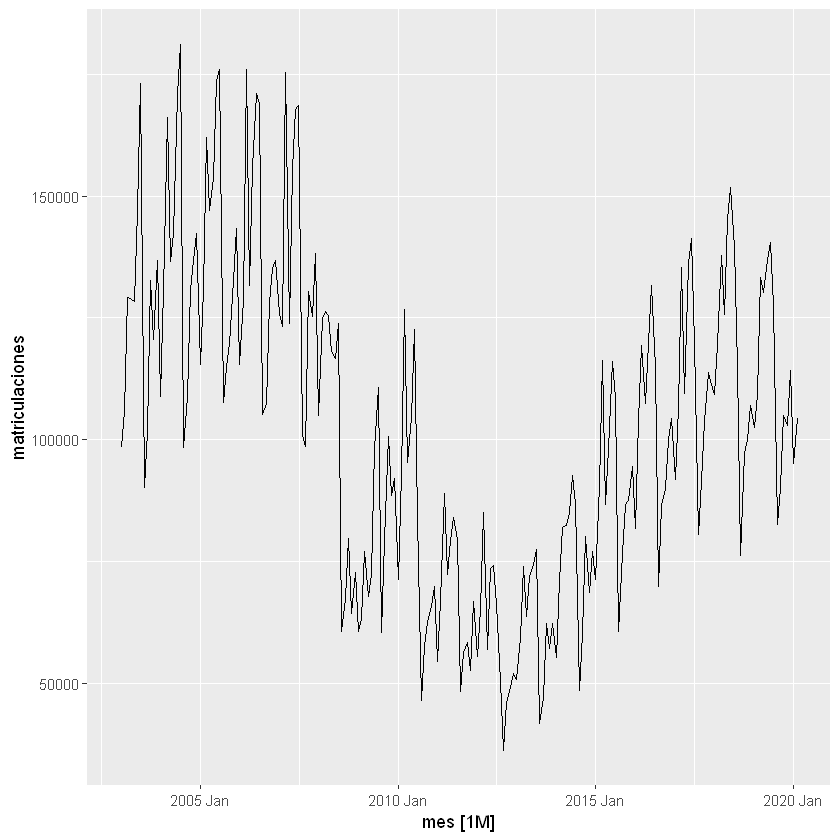

In [4]:
autoplot(serie_2020)

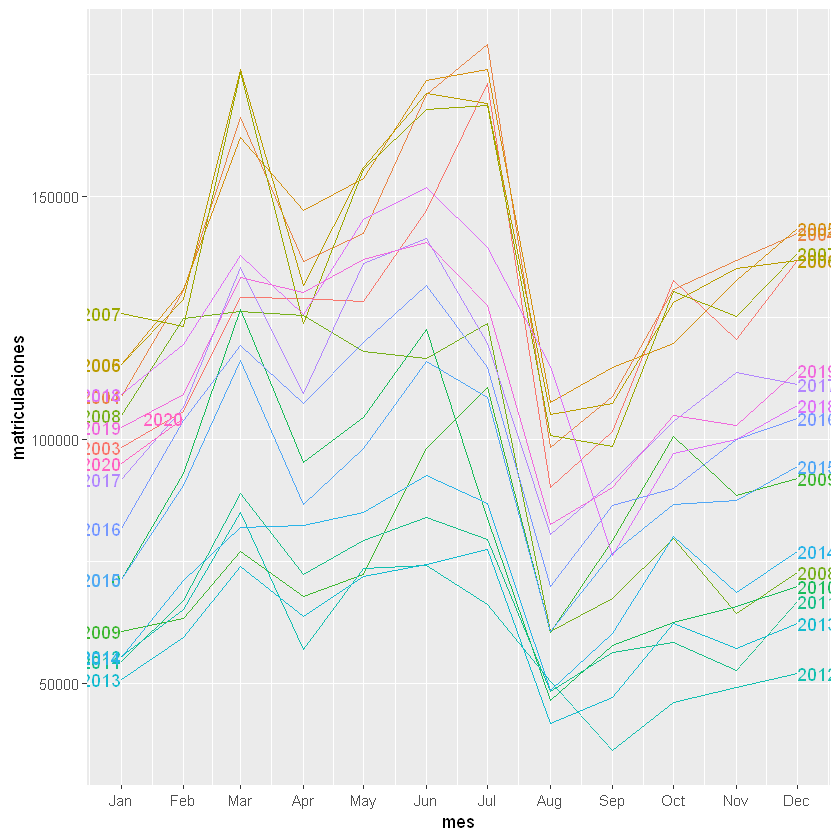

In [5]:
serie_2020 %>%
  gg_season(matriculaciones, labels = "both")

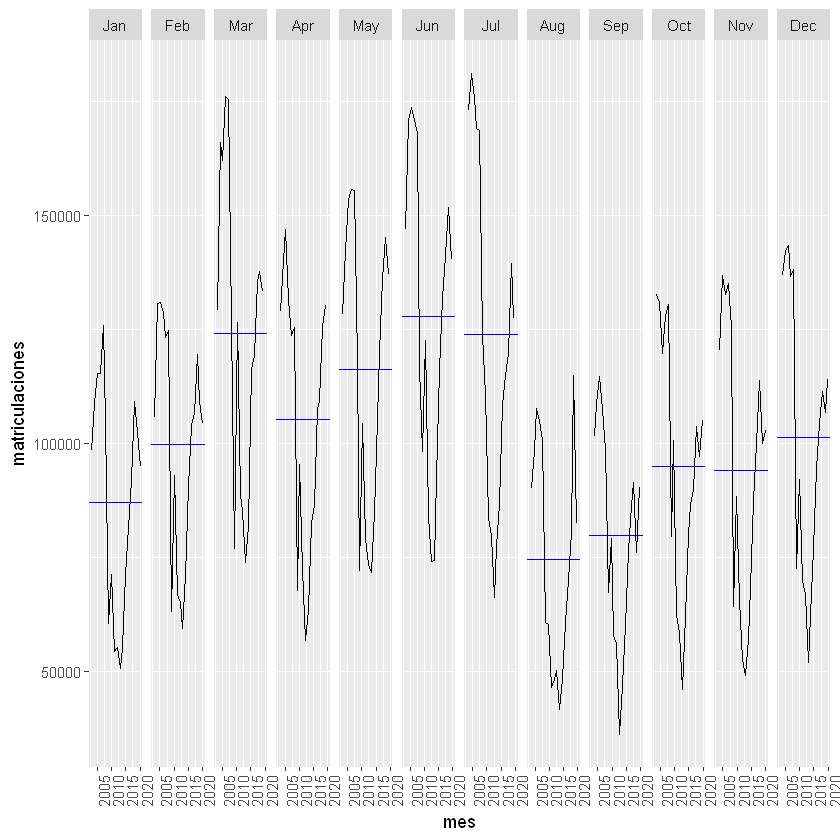

In [6]:
serie_2020 %>%
  gg_subseries(matriculaciones) 

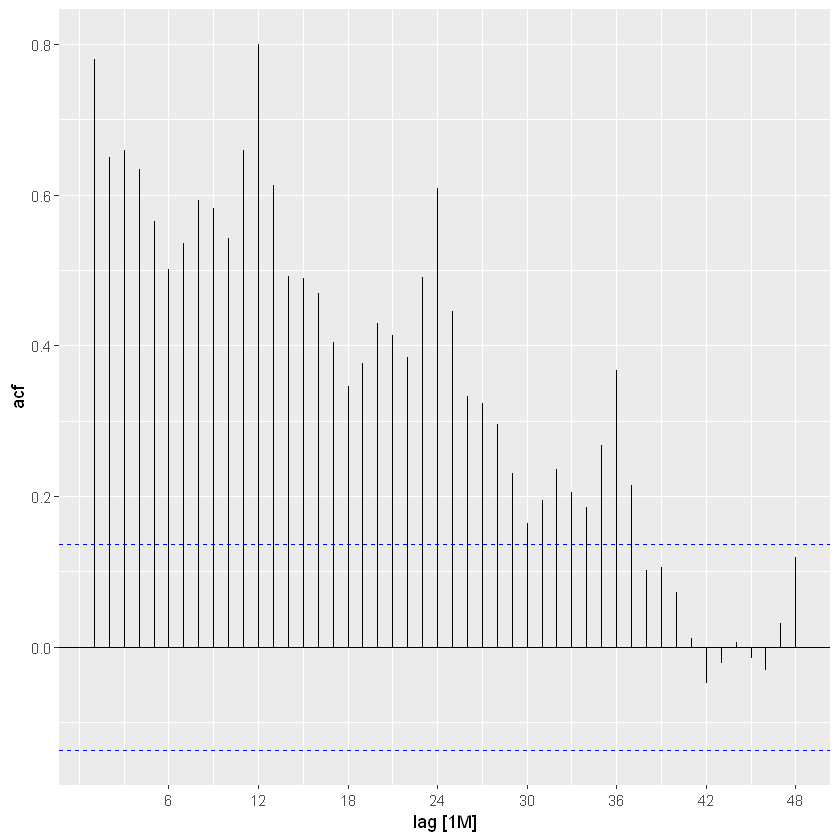

In [7]:
serie_2020 %>%
  ACF(matriculaciones, lag_max = 48) %>%
  autoplot() 

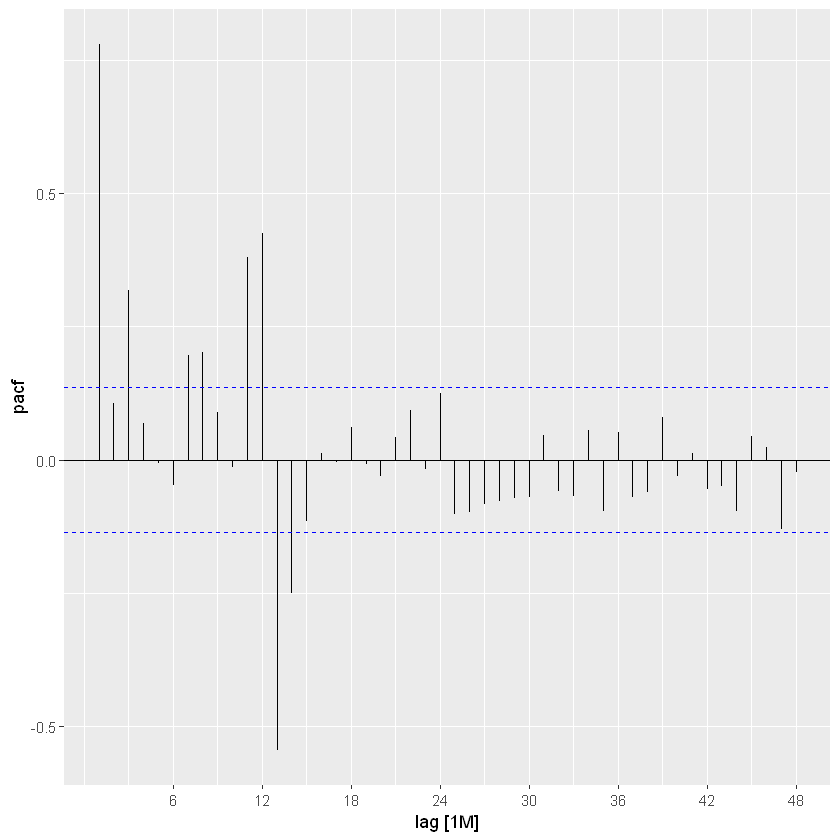

In [8]:
serie_2020 %>%
  PACF(matriculaciones, lag_max = 48) %>%
  autoplot() 

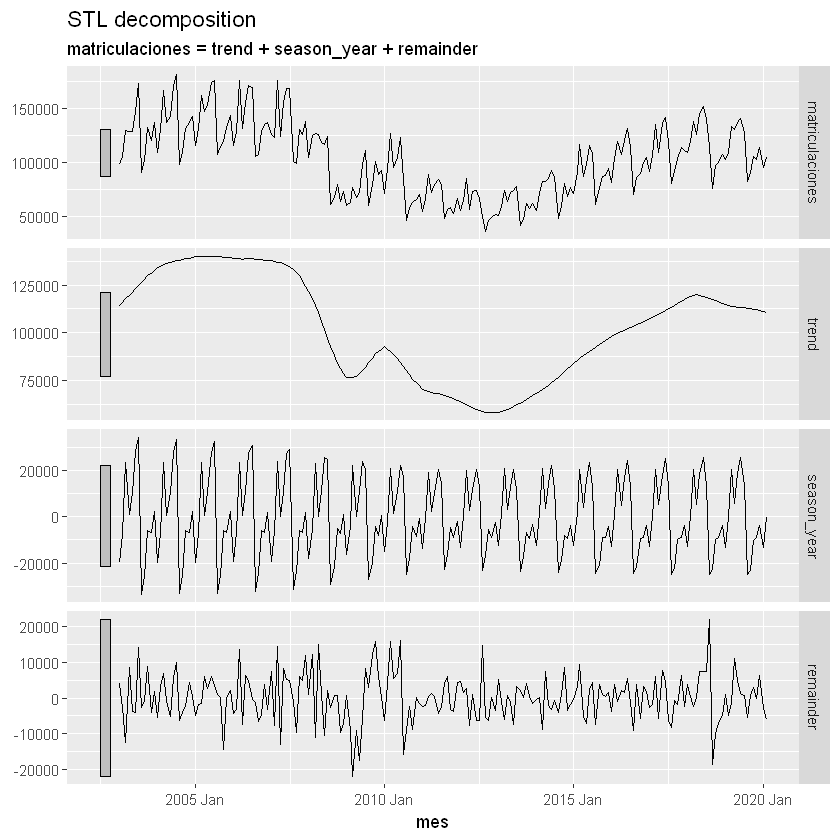

In [9]:
dcmp <- serie_2020 %>%
  model(stl = STL(matriculaciones))
components(dcmp) %>% autoplot()

In [10]:
fit <- serie_2020 %>%
  filter(year(mes) < "2018") %>%
  model(ARIMA(matriculaciones))

report(fit)

Series: matriculaciones 
Model: ARIMA(0,1,2)(1,1,1)[12] 

Coefficients:
          ma1     ma2    sar1     sma1
      -0.5880  0.1484  0.0539  -0.6337
s.e.   0.0833  0.0805  0.1391   0.1165

sigma^2 estimated as 106808016:  log likelihood=-1781.42
AIC=3572.84   AICc=3573.21   BIC=3588.43


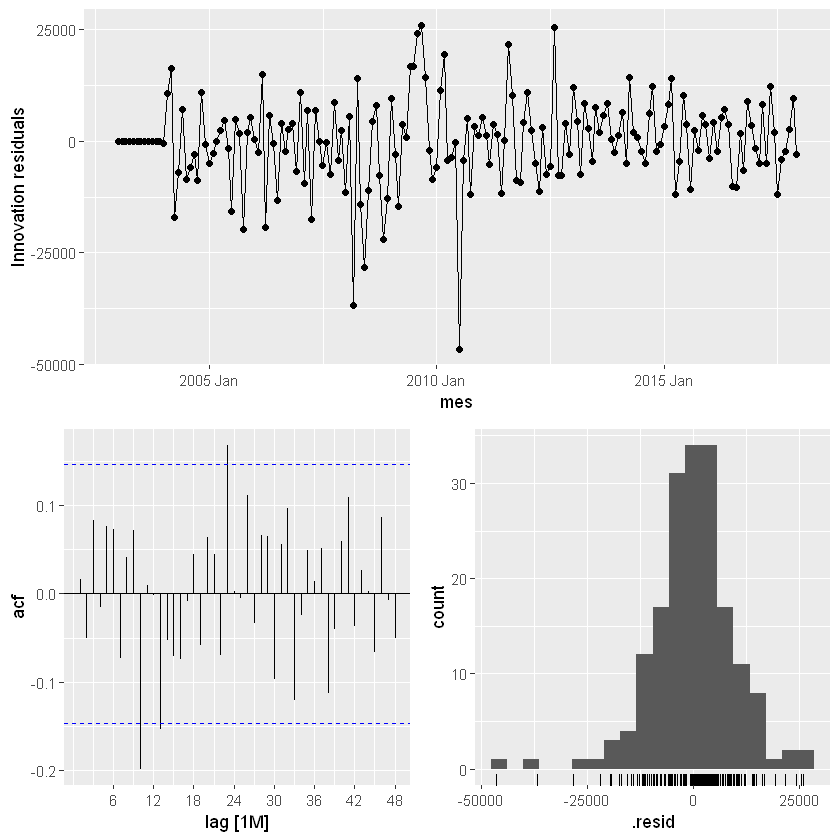

In [11]:
fit %>% gg_tsresiduals(lag_max=48)

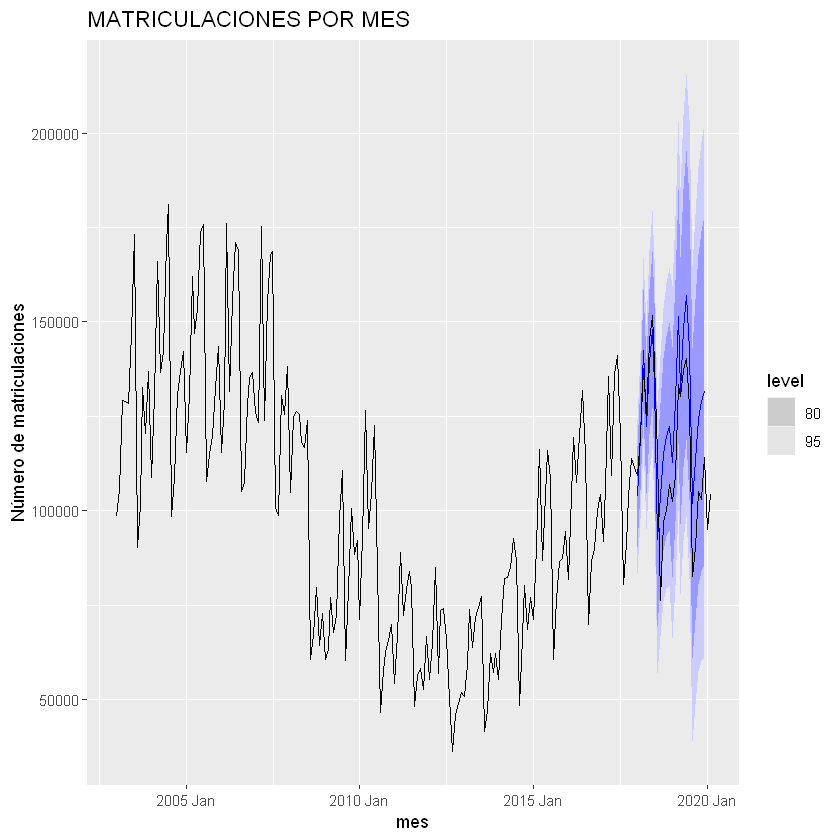

In [12]:
fit %>% forecast(h = 24) %>%
  autoplot(serie_2020) +
  labs(y = "Número de matriculaciones", title = "MATRICULACIONES POR MES")

## Serie 2022

Plot variable not specified, automatically selected `.vars = matriculaciones`



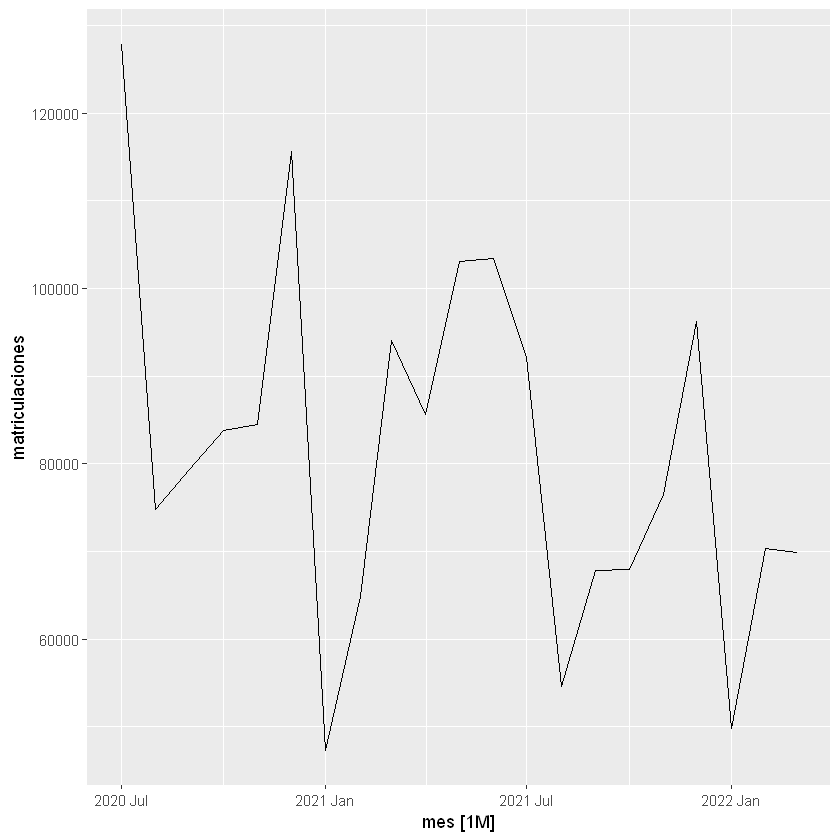

In [13]:
autoplot(serie_2022)

In [14]:
fit2 <- serie_2022 %>%
  model(ARIMA(matriculaciones))

report(fit)

Series: matriculaciones 
Model: ARIMA(0,1,2)(1,1,1)[12] 

Coefficients:
          ma1     ma2    sar1     sma1
      -0.5880  0.1484  0.0539  -0.6337
s.e.   0.0833  0.0805  0.1391   0.1165

sigma^2 estimated as 106808016:  log likelihood=-1781.42
AIC=3572.84   AICc=3573.21   BIC=3588.43


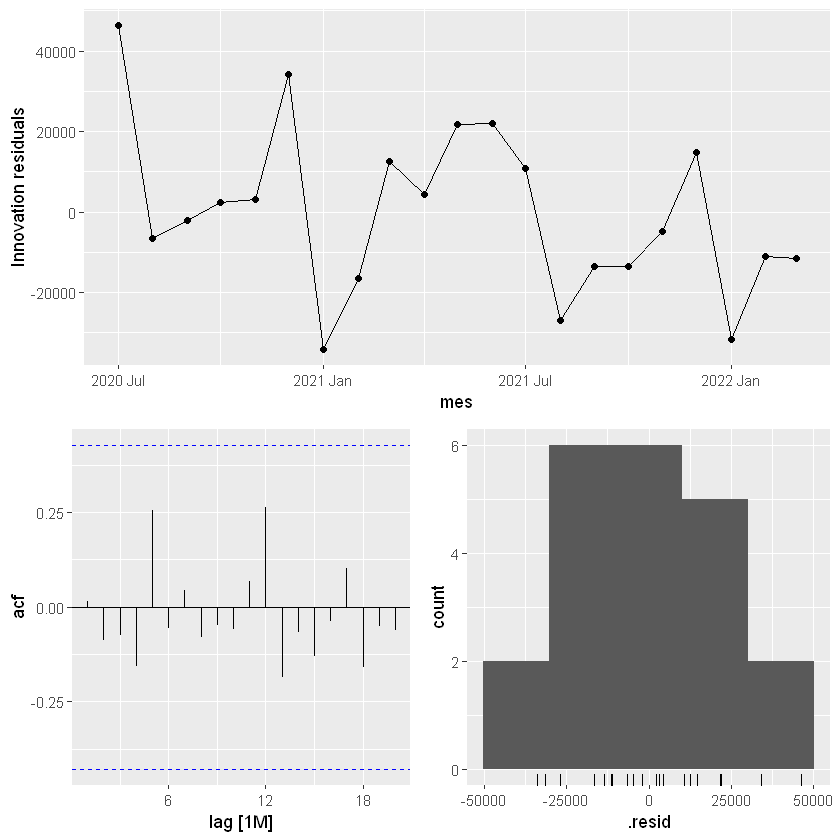

In [15]:
fit2 %>% gg_tsresiduals(lag_max=48)

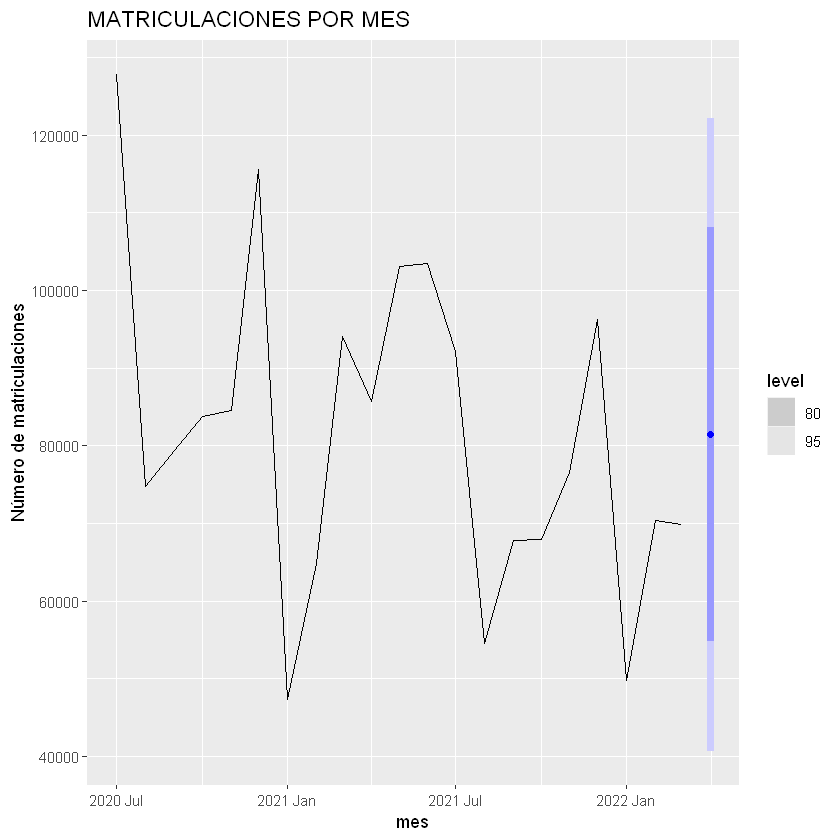

In [16]:
fit2 %>% forecast(h = 1) %>%
  autoplot(serie_2022) +
  labs(y = "Número de matriculaciones", title = "MATRICULACIONES POR MES")